In [2]:
import boto3
from PIL import Image
import io
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import random
import constants
import webdataset
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Take raw data and generate training and test data

Note, due to the random splitting of the training and test set, you should wipe the s3 bucket before doing this

In [2]:
MAX_PIXEL_VALUE = 65535
BUCKET_NAME = "cindy-profiling"
RAW_BASE_PATH = "TargetActivationAdvanced/"
CLEAN_BASE_PATH = "Data/"

In [4]:
def get_raw_image(image_name):
    s3 = boto3.client("s3")
    response = s3.get_object(Bucket = BUCKET_NAME, Key = RAW_BASE_PATH + image_name)
    content = response["Body"].read()
    image_file = io.BytesIO(content)
    image = Image.open(image_file)
    return image

In [5]:
files = []
s3 = boto3.resource("s3")
bucket = s3.Bucket("cindy-profiling")
for obj in bucket.objects.filter(Prefix = RAW_BASE_PATH):
    files.append(obj.key.split("/")[-1])

In [6]:
def gen_mask(d2_file):
    img = get_raw_image(d2_file)

    pixel_grid = np.array(img)
    num_rows = len(pixel_grid)
    linear_pixels = pixel_grid.flatten()
    pixel_stdev = np.std(linear_pixels, ddof =1)
    pixel_mean = linear_pixels.mean()
    pixel_threshold = pixel_mean + pixel_stdev * 1.5

    l_mask = []
    for pixel in linear_pixels:
        l_mask.append(1 if pixel > pixel_threshold else 0)

    np_mask = np.array(l_mask)
    mask = np_mask.reshape(num_rows, -1)

    masked_img = []
    for i, pixel in enumerate(np_mask):
        masked_img.append(MAX_PIXEL_VALUE if pixel == 1 else 0)
    masked_img = np.array(masked_img)
    masked_img = masked_img.reshape(num_rows, -1)
    return masked_img

In [7]:
masked_img = gen_mask("localhost231204150002_H02f07d2.TIFF")

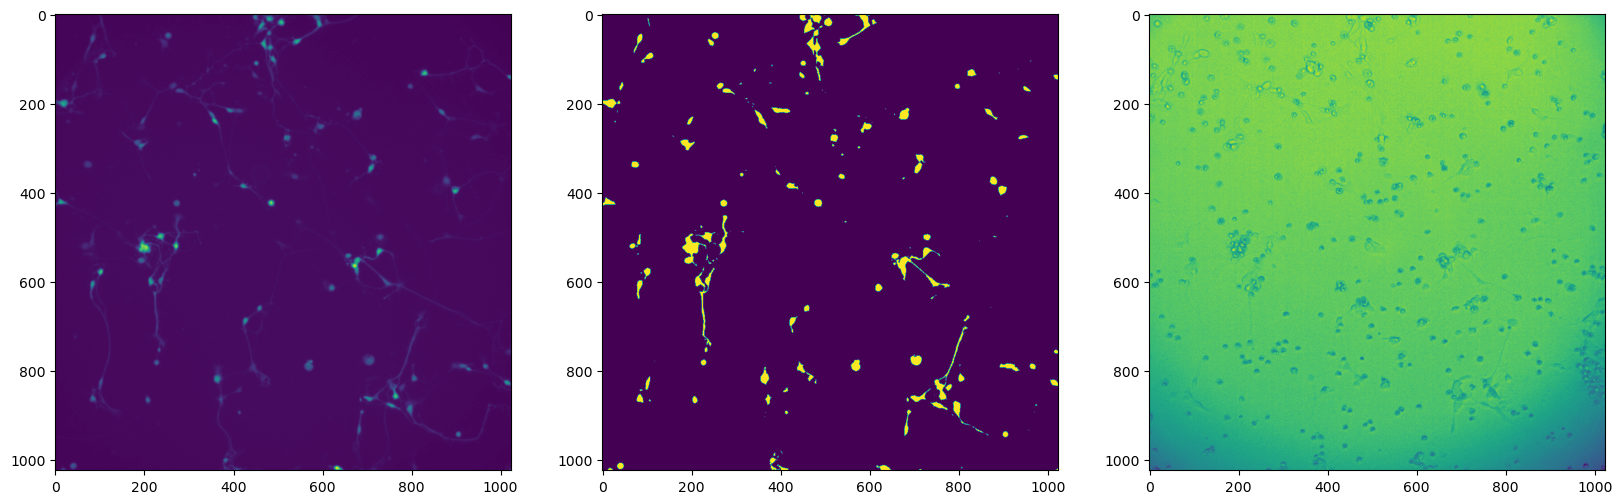

In [8]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))
axes[0].imshow(get_raw_image('localhost231204150002_H02f07d2.TIFF'))
axes[1].imshow(masked_img)
axes[2].imshow(get_raw_image("localhost231204150002_H02f07d3.TIFF"))

In [9]:
###
# DATA IS STRUCTURED filename, RGC image, Brightfield, Mask
###
data_pairs = []
misses = []
for file in tqdm(files):
  if file.split(".")[0][-1] == "2":
    brightfield = file.split(".")[0][:-1] + "3.TIFF"
    if brightfield in files:
      data_pairs.append([file, get_raw_image(file), get_raw_image(brightfield)])
    else:
      misses.append(brightfield)

100%|██████████| 1038/1038 [05:41<00:00,  3.04it/s]


In [10]:
for i in tqdm(range(len(data_pairs))):
  mask = gen_mask(data_pairs[i][0])
  data_pairs[i].append(mask)

 16%|█▌        | 41/259 [00:41<03:39,  1.01s/it]


KeyboardInterrupt: 

In [ ]:
pickle_byte_obj = pickle.dumps(data_pairs)
s3 = boto3.resource("s3")
bucket = s3.Bucket(BUCKET_NAME)
bucket.put_object(Key = CLEAN_BASE_PATH + "data_pairs.pkl", Body = pickle_byte_obj)

s3.Object(bucket_name='cindy-profiling', key='Data/data_pairs.pkl')

In [ ]:
# s3 = boto3.resource("s3")
# response = s3.get_object(Bucket = BUCKET_NAME, Key = CLEAN_BASE_PATH + "data_pairs.pkl")
# content = response["Body"].read()
# image_file = io.BytesIO(content)
# image = Image.open(image_file)

In [12]:
well_to_samples = {}
for file in files:
    identifier = file.split("_")[-1].split(".")[0]

    if file.split(".")[0][-2:] != "d3":
      continue
    well = identifier.split("f")[0]

    if well in well_to_samples:
        well_to_samples[well].add(identifier.split("f")[1])
    else:
        well_to_samples[well] = set([identifier.split("f")[1]])

for well in well_to_samples:
  well_to_samples[well] = list(well_to_samples[well])

In [13]:
TRAIN_RATIO = 0.8
VALIDATION_RATIO = 0
TEST_RATIO = 1 - (TRAIN_RATIO + VALIDATION_RATIO)
seed = 42
torch.manual_seed(seed)
random.seed(seed)

In [19]:
train_samples = []
test_samples = []
generator = torch.Generator().manual_seed(seed)
for well, samples in well_to_samples.items():
  train_subset, test_subset = random_split(samples, [TRAIN_RATIO, TEST_RATIO], generator = generator)
  train_list = [well + "f" + train_subset[i] for i in range(len(train_subset))]
  test_list = [well + "f" + test_subset[i] for i in range(len(test_subset))]
  train_samples += train_list
  test_samples += test_list

/opt/miniconda3/envs/f_mlbase/lib/python3.10/site-packages/torch/utils/data/dataset.py:449: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [15]:
print("Number of training samples: ",len(train_samples))
print("Number of test samples: ", len(test_samples))
print("% training samples: ", round(len(train_samples)/(len(train_samples) + len(test_samples)) * 100, 2) )

Number of training samples:  223
Number of test samples:  40
% training samples:  84.79


In [28]:
train_samples = [x[:-1] + "2" for x in train_samples]

In [30]:
train_data = []
test_data = []

for data_split in data_pairs:
  identifier = data_split[0].split("_")[-1].split(".")[0]
  if identifier in train_samples:
    train_data.append(data_split.copy())
  else:
    test_data.append(data_split.copy())

In [3]:
print(len(train_data))
print(len(test_data))

NameError: name 'train_data' is not defined

In [32]:
print(train_data[0][0])
train_data[0][0].split("_")[-1].split(".")[0][:-2]

localhost231204150002_A02f01d2.TIFF


'A02f01'

In [33]:
s3 = boto3.resource("s3")
bucket = s3.Bucket(BUCKET_NAME)

for train_pair in train_data:
    file_name = train_pair[0].split("_")[-1].split(".")[0][:-2]
    train_binary = pickle.dumps(train_pair)
    bucket.put_object(Key = CLEAN_BASE_PATH + f"train/{file_name}.pkl", Body = train_binary)
for test_pair in test_data:
    file_name = test_pair[0].split("_")[-1].split(".")[0][:-2]
    test_binary = pickle.dumps(test_pair)
    bucket.put_object(Key = CLEAN_BASE_PATH + f"test/{file_name}.pkl", Body = test_binary)

# Adjust data that is already on s3

Pull all train examples to construct web dataset tars

In [20]:
s3 = boto3.resource("s3")
bucket = s3.Bucket("cindy-profiling")

with webdataset.ShardWriter("shards/shard-%06d.tar", maxcount=40) as sink:
    idx = 0
    for obj in bucket.objects.filter(Prefix = constants.CLEAN_BASE_PATH + "train/"):
        response = obj.get()
        # print(response)
        content = pickle.loads(response["Body"].read())
        sink.write({
            "__key__": "%06d"%idx,
            "label" : content[0],
            "rgc_image.pyd": content[1],
            "brightfield.pyd": content[2],
            "mask.pyd":content[3]
        })
        idx += 1

# writing shards/shard-000000.tar 0 0.0 GB 0
# writing shards/shard-000001.tar 40 0.5 GB 40
# writing shards/shard-000002.tar 40 0.5 GB 80
# writing shards/shard-000003.tar 40 0.5 GB 120
# writing shards/shard-000004.tar 40 0.5 GB 160
# writing shards/shard-000005.tar 40 0.5 GB 200


In [37]:
shard_names = []
for i in range(6):
    shard_names.append(f"./shards/shard-00000{i}.tar")

In [50]:
train_transform = A.Compose(
[
    A.RandomCrop(height = constants.IMAGE_HEIGHT, width = constants.IMAGE_WIDTH, p = 1.0),
    A.Rotate(limit = 35, p = 1.0),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.1),
    A.Normalize(mean = 0, std = 1, max_pixel_value = constants.MAX_PIXEL_VALUE),
    ToTensorV2()
]
)

In [114]:
def identity(x):
    return x

def apply_mask_transformation(x):
    brightfield, mask = x[0], x[1]
    aug = train_transform(image = np.array(brightfield), mask = mask)
    return aug["image"][0], aug["mask"]

In [115]:
trainset = webdataset.WebDataset(shard_names, shardshuffle=True).shuffle(100).decode("pil").to_tuple("brightfield.pyd", "mask.pyd").map(apply_mask_transformation)

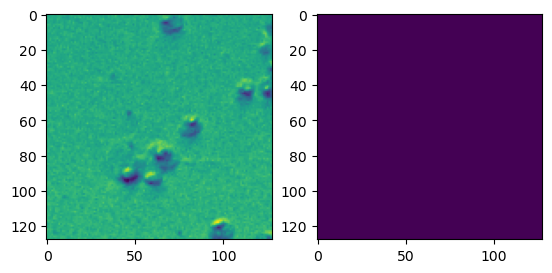

In [116]:
for x in trainset:
    brightfield = x[0]
    mask = x[1]
    

    fig, axes = plt.subplots(nrows = 1, ncols = 2)
    axes[0].imshow(brightfield)
    axes[1].imshow(mask)
    break

In [117]:
batch_size = 20
dataloader = DataLoader(trainset.batched(batch_size), num_workers = 4, batch_size = None)

In [3]:
s3 = boto3.resource("s3")
bucket = s3.Bucket("cindy-profiling")

with webdataset.ShardWriter("validation_shards/shard-%06d.tar", maxcount=40) as sink:
    idx = 0
    for obj in bucket.objects.filter(Prefix = constants.CLEAN_BASE_PATH + "test/"):
        response = obj.get()
        # print(response)
        content = pickle.loads(response["Body"].read())
        sink.write({
            "__key__": "%06d"%idx,
            "label" : content[0],
            "rgc_image.pyd": content[1],
            "brightfield.pyd": content[2],
            "mask.pyd":content[3]
        })
        idx += 1

# writing validation_shards/shard-000000.tar 0 0.0 GB 0


### One-time pruning to adjust badly added data

In [12]:
min_allowable_size = 10_000_000
max_allowable_size = 14_000_000
s3 = boto3.resource("s3")
bucket = s3.Bucket("cindy-profiling")
for obj in bucket.objects.filter(Prefix = constants.CLEAN_BASE_PATH + "train/"):
    if obj.size < min_allowable_size or obj.size > max_allowable_size:
        obj.delete()
for obj in bucket.objects.filter(Prefix = constants.CLEAN_BASE_PATH + "test/"):
    if obj.size < min_allowable_size or obj.size > max_allowable_size:
        obj.delete()

In [108]:
from torch.utils.data import Dataset
import os
import cv2

class DataPairsDataset(Dataset):
  def __init__(self, train_test, transform=None):
    self.train_test = train_test
    self.transform = transform

    self.images = []
    s3 = boto3.resource("s3")
    bucket = s3.Bucket("cindy-profiling")
    for obj in bucket.objects.filter(Prefix = f"Data/{self.train_test}/"):
        self.images.append(obj.key.split("/")[-1])

    self.images_container_path = f"{RAW_BASE_PATH}"


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    s3 = boto3.client("s3")
    response = s3.get_object(Bucket = BUCKET_NAME, Key = f"Data/{self.train_test}/{self.images[idx]}")
    pickled_data = pickle.loads(response["Body"].read())

    brightfield_path = pickled_data[1]
    brightfield_image = np.array(get_raw_image(brightfield_path))


    mask = pickled_data[2]
    mask[mask == 26113] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image = brightfield_image, mask = mask)
      brightfield_image = augmentations["image"]
      mask = augmentations["mask"]
    return brightfield_image, mask

[[5164 4893 5022 ... 4121 4152 4021]
 [5258 5219 5307 ... 4171 4010 4144]
 [5029 5189 5094 ... 4091 4201 4090]
 ...
 [4913 4816 4834 ... 3654 3704 3679]
 [4659 4702 4788 ... 3867 3699 3772]
 [4889 4790 4660 ... 3797 3707 3636]]


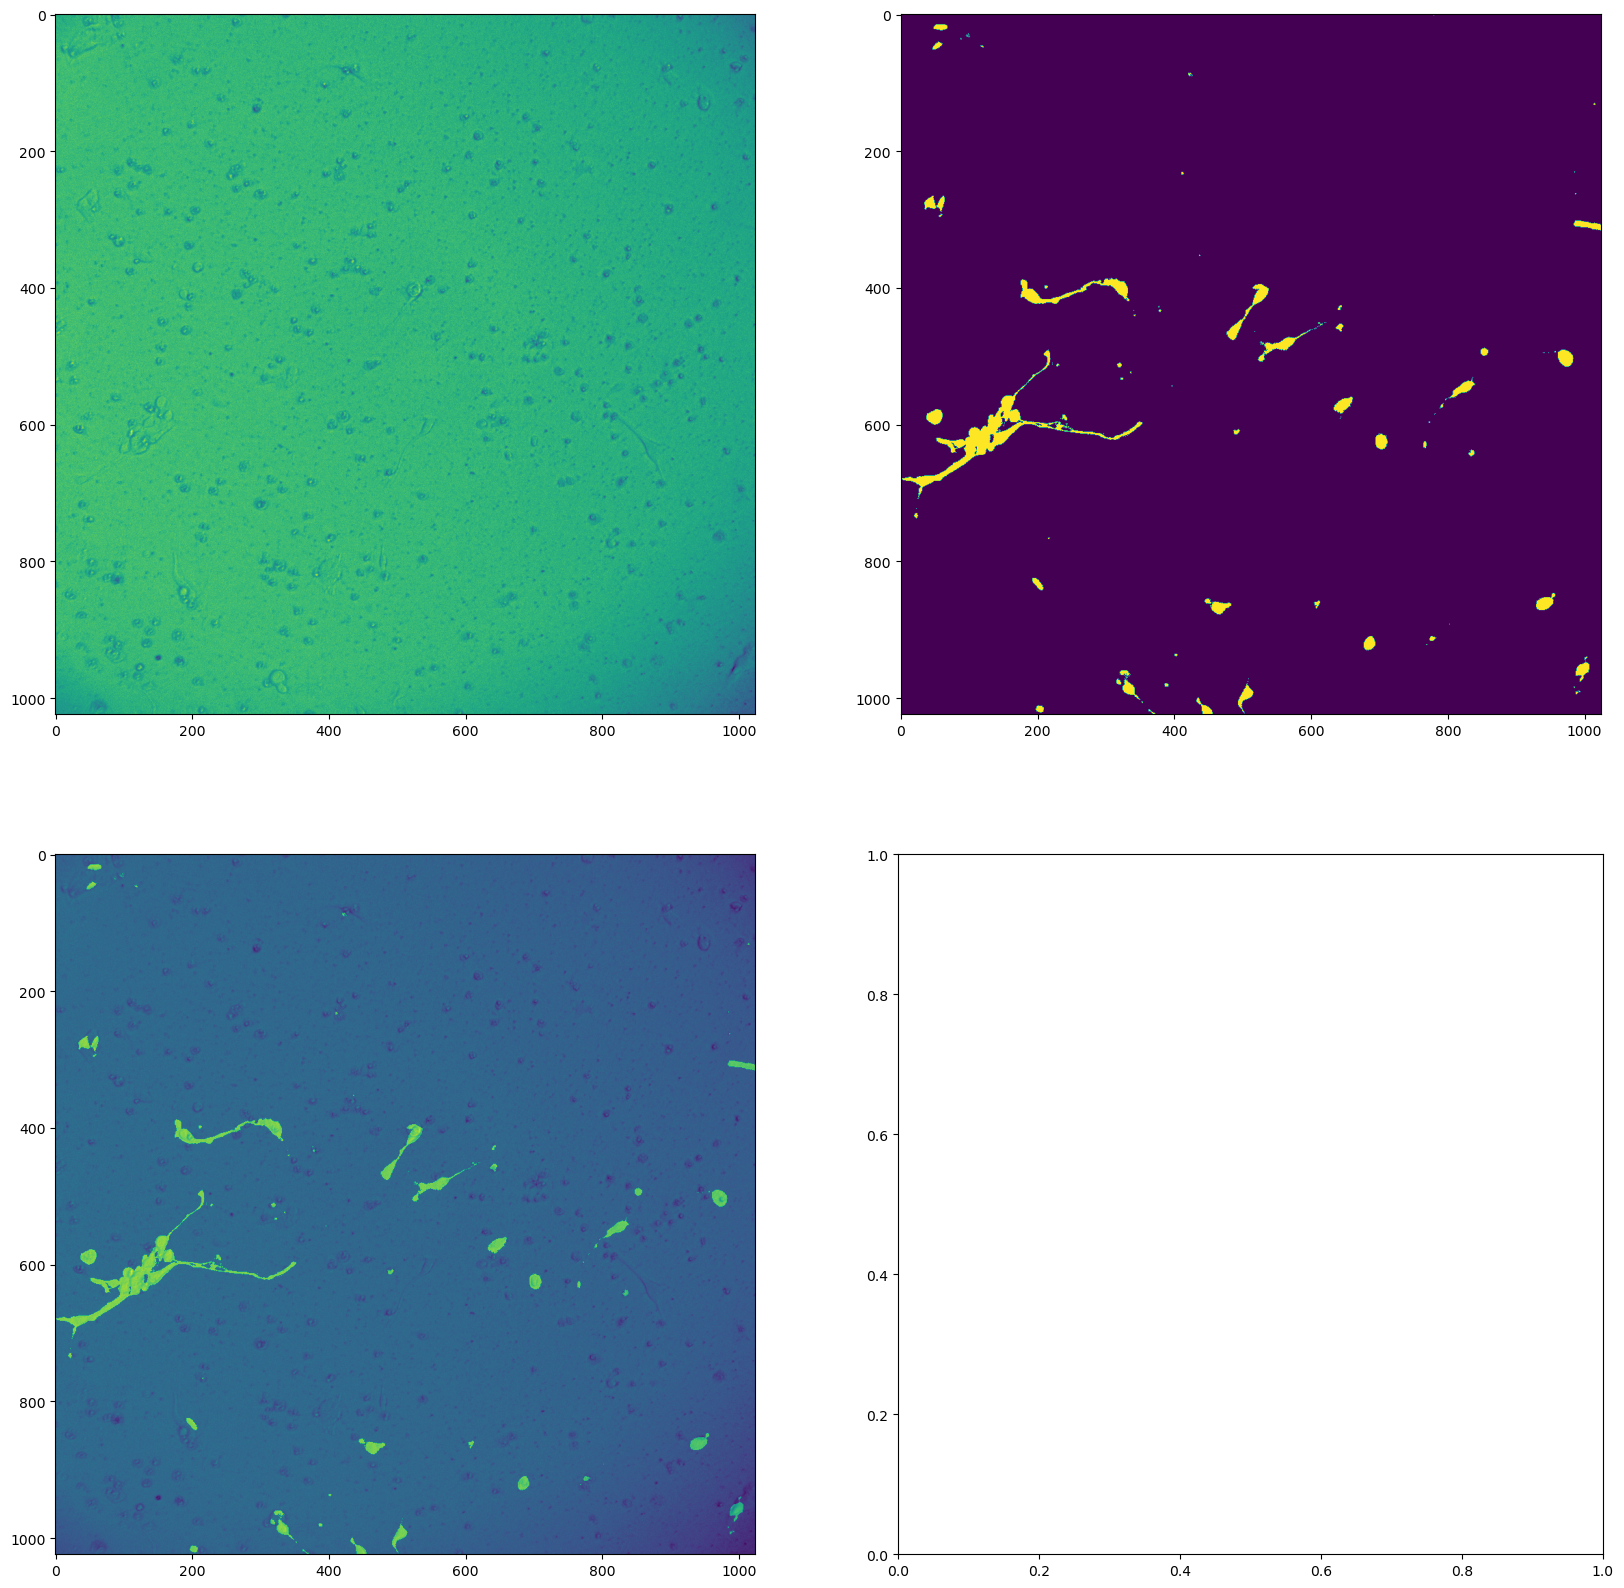

In [110]:
train_dataset = DataPairsDataset(train_test="test")
rand_index = np.random.randint(0, len(train_dataset), size = 1)[0]
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 20))
brightfield_image = train_dataset[rand_index][0]
mask = train_dataset[rand_index][1]
print(brightfield_image)
axes[0][0].imshow(brightfield_image)
axes[0][1].imshow(mask)

alpha = 0.95
axes[1][0].imshow(cv2.addWeighted(brightfield_image.astype(np.float32), alpha, mask.astype(np.float32), 1 - alpha, 0))
plt.show()

In [97]:
s3 = boto3.resource("s3")
bucket = s3.Bucket("cindy-profiling")
files = []
for obj in bucket.objects.filter(Prefix = f"Data/test"):
    files.append(obj.key.split("/")[-1])

In [99]:
s3 = boto3.client("s3")
response = s3.get_object(Bucket = BUCKET_NAME, Key = f"Data/test/A02f04.pkl")

In [102]:
obj = pickle.loads(response["Body"].read())

In [103]:
obj

['localhost231204150002_A02f04d2.TIFF',
 'localhost231204150002_A02f04d3.TIFF',
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [34]:
len(data_pairs)

259